In [1]:
import re
import csv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from numpy.lib.recfunctions import append_fields, drop_fields
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [2]:
plt.rcParams['figure.figsize'] = (8, 8)
# plt.style.use('ggplot')

In [3]:
dir = 'ml-latest-small'
genres = np.array(['Action', 'Adventure', 'Animation', "Children", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)'])

## Precessing

### Ratings

In [4]:
ratings = np.genfromtxt(
    f'{dir}/ratings.csv',
    delimiter=',',
    names=True,
    dtype=None,
)

ratings_year = ratings['timestamp'].astype('<M8[s]').astype('datetime64[Y]').astype(np.int64) + 1970
ratings = append_fields(ratings, 'year', ratings_year)
ratings = drop_fields(ratings, 'timestamp')

ratings

array([(  1,      1, 4., 2000), (  1,      3, 4., 2000),
       (  1,      6, 4., 2000), ..., (610, 168250, 5., 2017),
       (610, 168252, 5., 2017), (610, 170875, 3., 2017)],
      dtype=[('userId', '<i8'), ('movieId', '<i8'), ('rating', '<f8'), ('year', '<i8')])

### Movies

In [5]:
with open(f'{dir}/movies.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    movies_csv  = ('\t'.join(i) for i in reader)
    movies = np.genfromtxt(
        movies_csv,
        delimiter='\t',
        names=True,
        dtype=None,
        invalid_raise=False,
    )

year_patten = ' \((\d{4})\)'
movies_year = np.array([int(re.search(year_patten, i).group(1)) if re.search(year_patten, i) else np.nan for i in movies['title']])
movies = append_fields(movies, 'year', movies_year)

movies

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: ConversionWarning: Some errors were detected !
    Line #3203 (got 2 columns instead of 3)
    Line #5730 (got 2 columns instead of 3)
    Line #7557 (got 2 columns instead of 3)
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  if __name__ == '__main__':


masked_array(data=[(1, 'Toy Story (1995)', 'Adventure|Animation|Children|Comedy|Fantasy', 1995.0),
                   (2, 'Jumanji (1995)', 'Adventure|Children|Fantasy', 1995.0),
                   (3, 'Grumpier Old Men (1995)', 'Comedy|Romance', 1995.0),
                   ..., (193585, 'Flint (2017)', 'Drama', 2017.0),
                   (193587, 'Bungo Stray Dogs: Dead Apple (2018)', 'Action|Animation', 2018.0),
                   (193609, 'Andrew Dice Clay: Dice Rules (1991)', 'Comedy', 1991.0)],
             mask=[(False, False, False, False),
                   (False, False, False, False),
                   (False, False, False, False), ...,
                   (False, False, False, False),
                   (False, False, False, False),
                   (False, False, False, False)],
       fill_value=(999999, 'N/A', 'N/A', 1.e+20),
            dtype=[('movieId', '<i8'), ('title', '<U158'), ('genres', '<U77'), ('year', '<f8')])

### One-Hot genres in movies

In [6]:
movies_genres = np.array(np.zeros(movies.shape[0], dtype=bool), dtype=[(i, '<b') for i in genres])

for i, genre_str in enumerate(movies['genres']):
    genre_list = genre_str.split('|')
    movies_genres[genre_list][i] = True

movies_genres.shape

(9739,)

## Plot Chart

<BarContainer object of 119 artists>

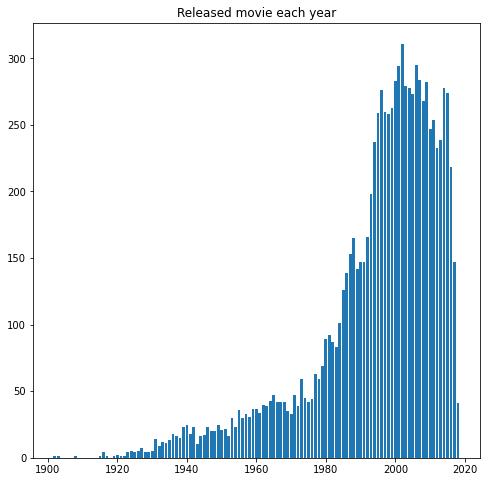

In [7]:
movies_year, movies_count = np.unique(movies['year'], return_counts=True)

plt.title('Released movie each year')
plt.bar(movies_year, movies_count)

<BarContainer object of 23 artists>

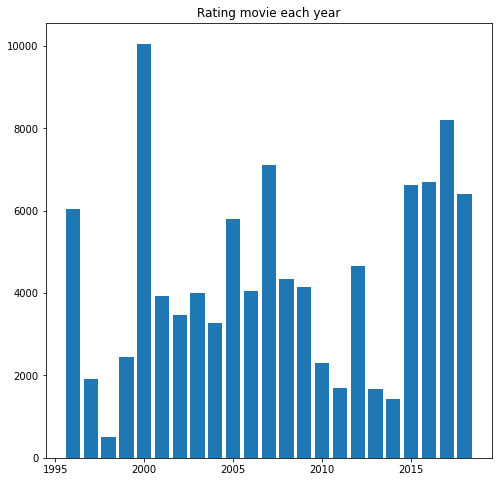

In [8]:
ratings_nonzero = ratings[np.nonzero(ratings['rating'])]
ratings_year, ratings_count = np.unique(ratings_nonzero['year'], return_counts=True)

plt.title('Rating movie each year')
plt.bar(ratings_year, ratings_count)

<BarContainer object of 20 artists>

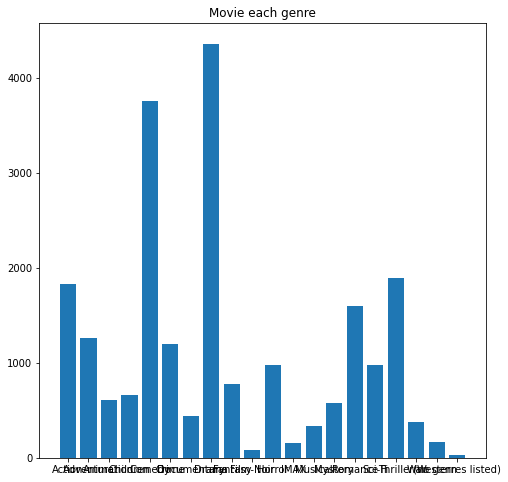

In [9]:
genres_count = movies_genres.view(np.bool).reshape(-1, genres.shape[0]).sum(axis=0)

plt.title('Movie each genre')
plt.bar(genres, genres_count)

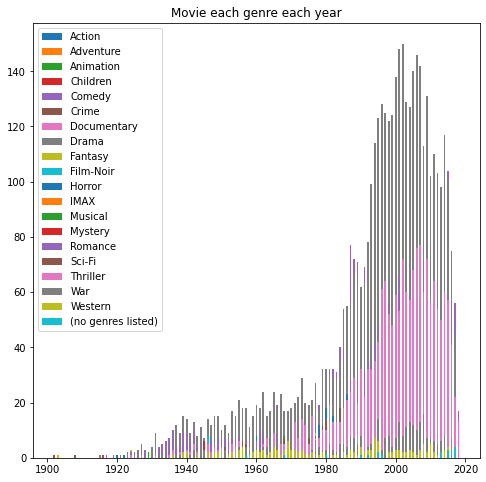

In [10]:
movie_year_idx = {i: (movies['year'] == i).nonzero()[0] for i in np.unique(movies['year'])}
movie_year_count = [movies_genres[movie_year_idx[i]].view(np.bool).reshape(-1, genres.shape[0]).sum(axis=0) for i in movie_year_idx.keys()]
movie_genres_count = np.stack(movie_year_count, axis=0).T

plt.title('Movie each genre each year')
for genres_count in movie_genres_count:
    plt.bar(movie_year_idx.keys(), genres_count, 0.5)
plt.legend(genres)

(array([  96.,    0.,   12.,    0.,  150.,    8.,   16.,   11.,  218.,
           8.,   22.,   61.,   34.,  450.,   85.,  125.,  144.,  559.,
          98.,  161.,  312.,  185., 1050.,  293.,  400.,  379., 1123.,
         309.,  529.,  343.,  265., 1138.,  185.,  176.,   58.,  379.,
           7.,   36.,    2.,  297.]),
 array([0.5   , 0.6125, 0.725 , 0.8375, 0.95  , 1.0625, 1.175 , 1.2875,
        1.4   , 1.5125, 1.625 , 1.7375, 1.85  , 1.9625, 2.075 , 2.1875,
        2.3   , 2.4125, 2.525 , 2.6375, 2.75  , 2.8625, 2.975 , 3.0875,
        3.2   , 3.3125, 3.425 , 3.5375, 3.65  , 3.7625, 3.875 , 3.9875,
        4.1   , 4.2125, 4.325 , 4.4375, 4.55  , 4.6625, 4.775 , 4.8875,
        5.    ]),
 <a list of 40 Patch objects>)

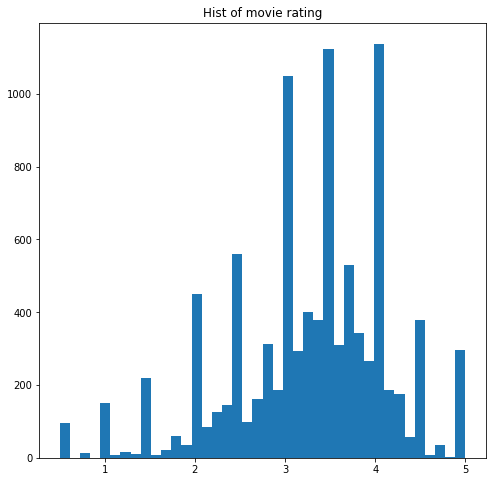

In [11]:
movie_id, movie_idx, movie_count = np.unique(ratings_nonzero['movieId'], return_inverse=True, return_counts=True)
movie_sum = np.bincount(movie_idx, weights=ratings_nonzero['rating'])
movie_mean = movie_sum / movie_count

plt.title('Hist of movie rating')
plt.hist(movie_mean, bins=40)

## Rec Sys from user_martix

### One-Hot user review

In [12]:
user_id = np.unique(ratings['userId'])
user_ratings = np.array(np.zeros(user_id.shape[0]), dtype=[(str(i), '<f8') for i in movies['movieId']])

for i, rating in enumerate(ratings):
    try:
        user_ratings[str(rating['movieId'])][rating['userId'] -1] = rating['rating']
    except Exception as e:
        print(e)

no field of name 85354
no field of name 4317
no field of name 85354
no field of name 85354
no field of name 27899
no field of name 4317
no field of name 27899
no field of name 4317


### Cosine Similarity

In [13]:
N_CHOICE = 20
user_id_choice = np.random.choice(user_id, N_CHOICE)
user_rating_choice = user_ratings[user_id_choice].view(np.float64).reshape(-1, movies['movieId'].shape[0])

user_cse = cosine_similarity(user_rating_choice)

# user_cse1

### Standard Correlation Coefficient

In [14]:
user_cof = np.corrcoef(user_rating_choice)

# user_cof

## Table of top 5 user similarity

In [15]:
sim_score = sorted(list(enumerate(user_cse.reshape(-1))), key=lambda x: x[1], reverse=True)
sim_sort_score =  list(filter( lambda x:( x[0]// N_CHOICE)+(N_CHOICE*(( x[0]-( x[0] % N_CHOICE))//N_CHOICE)) > x[0], sim_score))
user_cse_top5 = np.array([(i%N_CHOICE, i//N_CHOICE, score) for i, score in sim_sort_score[:5]], dtype=[('user_id', '<i8'), ('user_sim_id', '<i8'), ('sim_score', '<f8')])

user_cse_top5

array([(3,  4, 0.50867442), (2, 14, 0.50087031), (2,  3, 0.49696987),
       (3, 16, 0.48982666), (3, 14, 0.48275181)],
      dtype=[('user_id', '<i8'), ('user_sim_id', '<i8'), ('sim_score', '<f8')])

In [16]:
sim_score = sorted(list(enumerate(user_cof.reshape(-1))), key=lambda x: x[1], reverse=True)
sim_sort_score =  list(filter( lambda x:( x[0]// N_CHOICE)+(N_CHOICE*(( x[0]-( x[0] % N_CHOICE))//N_CHOICE)) > x[0], sim_score))
user_cof_top5 = np.array([(i%N_CHOICE, i//N_CHOICE, score) for i, score in sim_sort_score[:5]], dtype=[('user_id', '<i8'), ('user_sim_id', '<i8'), ('sim_score', '<f8')])

user_cof_top5

array([(3,  4, 0.50634176), (2, 14, 0.49631147), (2,  3, 0.49313311),
       (3, 16, 0.4880936 ), (3, 14, 0.47774565)],
      dtype=[('user_id', '<i8'), ('user_sim_id', '<i8'), ('sim_score', '<f8')])

## Table of top 5 user neg similarity

In [17]:
sim_score = sorted(list(enumerate(user_cof.reshape(-1))), key=lambda x: x[1])
sim_sort_score =  list(filter( lambda x:( x[0]// N_CHOICE)+(N_CHOICE*(( x[0]-( x[0] % N_CHOICE))//N_CHOICE)) > x[0], sim_score))
user_neg_cof_top5 = np.array([(i%N_CHOICE, i//N_CHOICE, score) for i, score in sim_sort_score[:5]], dtype=[('user_id', '<i8'), ('user_sim_id', '<i8'), ('sim_score', '<f8')])

user_neg_cof_top5

array([( 7, 11, -0.00451185), ( 8,  9, -0.00413044),
       (13, 17, -0.00357739), (11, 17, -0.00239969),
       ( 9, 17, -0.00197295)],
      dtype=[('user_id', '<i8'), ('user_sim_id', '<i8'), ('sim_score', '<f8')])

## Heatmap similarity

[Text(0, 0, '198'),
 Text(0, 0, '117'),
 Text(0, 0, '37'),
 Text(0, 0, '469'),
 Text(0, 0, '132'),
 Text(0, 0, '253'),
 Text(0, 0, '75'),
 Text(0, 0, '358'),
 Text(0, 0, '503'),
 Text(0, 0, '277'),
 Text(0, 0, '336'),
 Text(0, 0, '471'),
 Text(0, 0, '312'),
 Text(0, 0, '343'),
 Text(0, 0, '313'),
 Text(0, 0, '287'),
 Text(0, 0, '573'),
 Text(0, 0, '292'),
 Text(0, 0, '98'),
 Text(0, 0, '124')]

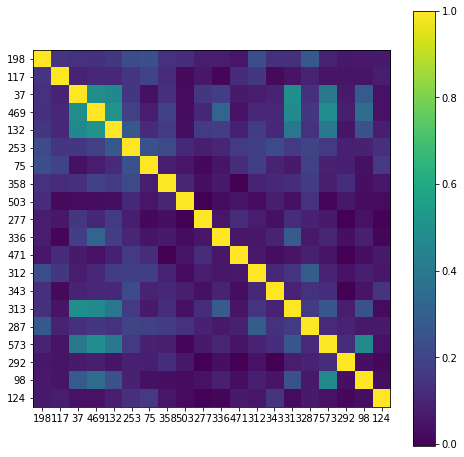

In [18]:
fig, ax = plt.subplots()
im = ax.imshow(user_cof)
fig.colorbar(im)
ax.set_xticks(np.arange(user_id_choice.shape[0]))
ax.set_yticks(np.arange(user_id_choice.shape[0]))
ax.set_yticklabels(user_id_choice)
ax.set_xticklabels(user_id_choice)

### Graph similarity

In [19]:
G = nx.Graph()

for i in user_id_choice:
    G.add_node(i)

Th = [0.5, 0.4, 0.3, 0.006, 0.005, 0.004]
Col = ['#001eff', '#00e5ff', '#00ffd0', '#ff0000', '#ff9900', '#fff200']
Wid = [300, 200, 100, 300, 200, 100]

for x in range(user_id_choice.shape[0]):
    for y in range(user_id_choice.shape[0]):
        for i in range(3):
            if user_cof[x, y] > Th[i]:
                G.add_edge(
                    user_id_choice[x],user_id_choice[y],
                    weight = 1,
                    color=Col[i],width=Wid[i])
                break
        for i in range(3, 6):
            if -1*user_cof[x, y] > Th[i]:
                G.add_edge(
                    user_id_choice[x],user_id_choice[y],
                    weight = 1,
                    color=Col[i],width=Wid[i]) 
                break

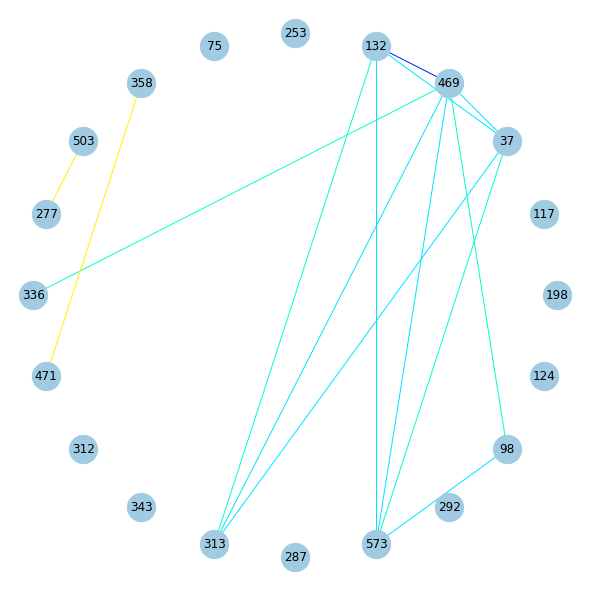

In [20]:
pos = nx.circular_layout(G)

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]

nx.draw(G, pos,with_labels = True, edges=edges, edge_color=colors, width=weights,node_color='#A0CBE2',node_size=800)

## Table of hight movie rating chose suggestm

In [21]:
user_s = []
for i in range(user_cof.shape[0]):
    score = sorted(list(enumerate(user_cof[i])), key = lambda x:x[1], reverse=True)
    user_s.append((i ,score[1][0]))
    
user_sim = [(user_id_choice[i], user_id_choice[j]) for i, j in user_s]

user_sim

[(198, 287),
 (117, 75),
 (37, 313),
 (469, 132),
 (132, 469),
 (253, 132),
 (75, 253),
 (358, 253),
 (503, 287),
 (277, 132),
 (336, 469),
 (471, 253),
 (312, 287),
 (343, 253),
 (313, 37),
 (287, 312),
 (573, 469),
 (292, 358),
 (98, 573),
 (124, 75)]

In [22]:
g = []
for i in user_sim:
    ai = ratings[(ratings['userId'] == i[1])]['rating'].argmax(axis=0)
    rt = ratings[(ratings['userId'] == i[1])][ai]
    mv = movies[movies['movieId'] == rt['movieId']]
    g.append((i[0], i[1], mv['title'][0], rt['rating']))

user_suggest = np.array(g, dtype=[('user_id', '<i8'), ('user_similarity_id', '<i8'), ('title', '<U158'), ('rating', '<f8')])

user_suggest

array([(198, 287, 'Heavenly Creatures (1994)', 5. ),
       (117,  75, 'Star Wars: Episode IV - A New Hope (1977)', 5. ),
       ( 37, 313, 'Seven (a.k.a. Se7en) (1995)', 5. ),
       (469, 132, 'Shawshank Redemption, The (1994)', 4.5),
       (132, 469, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 5. ),
       (253, 132, 'Shawshank Redemption, The (1994)', 4.5),
       ( 75, 253, 'Farewell My Concubine (Ba wang bie ji) (1993)', 5. ),
       (358, 253, 'Farewell My Concubine (Ba wang bie ji) (1993)', 5. ),
       (503, 287, 'Heavenly Creatures (1994)', 5. ),
       (277, 132, 'Shawshank Redemption, The (1994)', 4.5),
       (336, 469, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 5. ),
       (471, 253, 'Farewell My Concubine (Ba wang bie ji) (1993)', 5. ),
       (312, 287, 'Heavenly Creatures (1994)', 5. ),
       (343, 253, 'Farewell My Concubine (Ba wang bie ji) (1993)', 5. ),
       (313,  37, 'Apollo 13 (1995)', 5. ),
       (287, 312, 'Taxi Driver (1976)', 5. ),
       (573, 469,

## Table of hight movie rating not chose suggestm

In [23]:
user_s = []
for i in range(user_cof.shape[0]):
    score = sorted(list(enumerate(user_cof[i])), key = lambda x:x[1])
    user_s.append((i ,score[1][0]))
    
user_sim_neg = [(user_id_choice[i], user_id_choice[j]) for i, j in user_s]

user_sim_neg

[(198, 292),
 (117, 503),
 (37, 75),
 (469, 471),
 (132, 292),
 (253, 292),
 (75, 98),
 (358, 98),
 (503, 573),
 (277, 292),
 (336, 124),
 (471, 292),
 (312, 292),
 (343, 117),
 (313, 503),
 (287, 98),
 (573, 124),
 (292, 471),
 (98, 124),
 (124, 336)]

In [24]:
g = []
for i in user_sim_neg:
    ai = ratings[(ratings['userId'] == i[1])]['rating'].argmax(axis=0)
    rt = ratings[(ratings['userId'] == i[1])][ai]
    mv = movies[movies['movieId'] == rt['movieId']]
    g.append((i[0], i[1], mv['title'][0], rt['rating']))

user_suggest = np.array(g, dtype=[('user_id', '<i8'), ('user_similarity_id', '<i8'), ('title', '<U158'), ('rating', '<f8')])

user_suggest

array([(198, 292, 'Shawshank Redemption, The (1994)', 5.),
       (117, 503, 'Basketball Diaries, The (1995)', 5.),
       ( 37,  75, 'Star Wars: Episode IV - A New Hope (1977)', 5.),
       (469, 471, 'Toy Story (1995)', 5.),
       (132, 292, 'Shawshank Redemption, The (1994)', 5.),
       (253, 292, 'Shawshank Redemption, The (1994)', 5.),
       ( 75,  98, 'Forrest Gump (1994)', 5.),
       (358,  98, 'Forrest Gump (1994)', 5.),
       (503, 573, 'Toy Story (1995)', 5.),
       (277, 292, 'Shawshank Redemption, The (1994)', 5.),
       (336, 124, 'Forrest Gump (1994)', 5.),
       (471, 292, 'Shawshank Redemption, The (1994)', 5.),
       (312, 292, 'Shawshank Redemption, The (1994)', 5.),
       (343, 117, 'Braveheart (1995)', 5.),
       (313, 503, 'Basketball Diaries, The (1995)', 5.),
       (287,  98, 'Forrest Gump (1994)', 5.),
       (573, 124, 'Forrest Gump (1994)', 5.),
       (292, 471, 'Toy Story (1995)', 5.),
       ( 98, 124, 'Forrest Gump (1994)', 5.),
       (124, 33

## Rec Sys from item_matrix

In [25]:
genre_id_choice = np.random.choice(movies.shape[0], N_CHOICE)
genre_choice = movies_genres[genre_id_choice].view(np.bool).reshape(-1, genres.shape[0])

In [26]:
genre_cse = cosine_similarity(genre_choice)
genre_cof = np.corrcoef(genre_cse)

## Table of top 5 genres similarity

In [27]:
sim_score = sorted(list(enumerate(genre_cof.reshape(-1))), key=lambda x: x[1], reverse=True)
sim_sort_score =  list(filter( lambda x:( x[0]// N_CHOICE)+(N_CHOICE*(( x[0]-( x[0] % N_CHOICE))//N_CHOICE)) > x[0], sim_score))
genre_cse_top5 = np.array([(i%N_CHOICE, i//N_CHOICE, movies[movies['movieId'] == i%N_CHOICE]['title'][0], movies[movies['movieId'] == i//N_CHOICE]['title'][0], score) for i, score in sim_sort_score[:5]], dtype=[('movie_id', '<f8'), ('movid_sim_id', '<f8'), ('movie_title', '<U158'), ('movie_sim_title', '<U158'), ('sim_score', '<f8')])

genre_cse_top5

array([( 4.,  9., 'Waiting to Exhale (1995)', 'Sudden Death (1995)', 1.        ),
       ( 1., 12., 'Toy Story (1995)', 'Dracula: Dead and Loving It (1995)', 1.        ),
       ( 1., 17., 'Toy Story (1995)', 'Sense and Sensibility (1995)', 1.        ),
       (12., 17., 'Dracula: Dead and Loving It (1995)', 'Sense and Sensibility (1995)', 1.        ),
       (11., 13., 'American President, The (1995)', 'Balto (1995)', 0.95740627)],
      dtype=[('movie_id', '<f8'), ('movid_sim_id', '<f8'), ('movie_title', '<U158'), ('movie_sim_title', '<U158'), ('sim_score', '<f8')])

## Table of top 5 genres not similarity

In [28]:
sim_score = sorted(list(enumerate(genre_cof.reshape(-1))), key=lambda x: x[1])
sim_sort_score =  list(filter( lambda x:( x[0]// N_CHOICE)+(N_CHOICE*(( x[0]-( x[0] % N_CHOICE))//N_CHOICE)) > x[0], sim_score))
genre_cse_neg_top5 = np.array([(i%N_CHOICE, i//N_CHOICE, movies[movies['movieId'] == i%N_CHOICE]['title'][0], movies[movies['movieId'] == i//N_CHOICE]['title'][0], score) for i, score in sim_sort_score[:5]], dtype=[('movie_id', '<f8'), ('movid_sim_id', '<f8'), ('movie_title', '<U158'), ('movie_sim_title', '<U158'), ('sim_score', '<f8')])

genre_cse_neg_top5

array([(14., 18., 'Nixon (1995)', 'Four Rooms (1995)', -0.79954781),
       (14., 19., 'Nixon (1995)', 'Ace Ventura: When Nature Calls (1995)', -0.79248687),
       ( 4., 18., 'Waiting to Exhale (1995)', 'Four Rooms (1995)', -0.76923304),
       ( 9., 18., 'Sudden Death (1995)', 'Four Rooms (1995)', -0.76923304),
       (15., 18., 'Cutthroat Island (1995)', 'Four Rooms (1995)', -0.7598282 )],
      dtype=[('movie_id', '<f8'), ('movid_sim_id', '<f8'), ('movie_title', '<U158'), ('movie_sim_title', '<U158'), ('sim_score', '<f8')])

## Table of hight movie rating chose suggestm

In [29]:
g = []
for i in genre_cse_top5:
    ai = ratings[(ratings['movieId'] == i['movie_id']) & (ratings['rating'] > 3)][:5]
    for aai in ai:
        g.append((aai[0], i[0], i[2], i[3], i[4], aai[2]))

user_suggest = np.array(g, dtype=[('user_id', '<i8'), ('movie_id', '<i8'), ('movie_title', '<U158'), ('movie_suggest_title', '<U158'), ('sim_score', '<f8'), ('rating', '<f8')])

user_suggest

array([(  1,  1, 'Toy Story (1995)', 'Dracula: Dead and Loving It (1995)', 1.        , 4. ),
       (  5,  1, 'Toy Story (1995)', 'Dracula: Dead and Loving It (1995)', 1.        , 4. ),
       (  7,  1, 'Toy Story (1995)', 'Dracula: Dead and Loving It (1995)', 1.        , 4.5),
       ( 17,  1, 'Toy Story (1995)', 'Dracula: Dead and Loving It (1995)', 1.        , 4.5),
       ( 18,  1, 'Toy Story (1995)', 'Dracula: Dead and Loving It (1995)', 1.        , 3.5),
       (  1,  1, 'Toy Story (1995)', 'Sense and Sensibility (1995)', 1.        , 4. ),
       (  5,  1, 'Toy Story (1995)', 'Sense and Sensibility (1995)', 1.        , 4. ),
       (  7,  1, 'Toy Story (1995)', 'Sense and Sensibility (1995)', 1.        , 4.5),
       ( 17,  1, 'Toy Story (1995)', 'Sense and Sensibility (1995)', 1.        , 4.5),
       ( 18,  1, 'Toy Story (1995)', 'Sense and Sensibility (1995)', 1.        , 3.5),
       (274, 12, 'Dracula: Dead and Loving It (1995)', 'Sense and Sensibility (1995)', 1.        , 3